# 10. Convolutional Neural Networks

Please work on Google Colab. (No.)

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

from IPython.display import display

In [2]:
from hw_utils import *
from hw_models import *

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import tensorflow.keras.callbacks as kc

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [4]:
print(tf.__version__)

2.5.0-dev20201128


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17421117140493085022,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5060693856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2090596113998737435
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [8]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [9]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Load the MNIST dataset and create a CNN model

- load the MNIST dataset from the tensorflow/keras built-in dataset (just like last time)
- use the original train/test split!
- divide each pixel's value by 255 and now do not reshape, leave it as is (2D matrix (28x28) )
- eg for the test set you will have a (10000, 28, 28) shaped vector
- train the following network on the training set and generate prediction for the 10.000 test images:

        input (28, 28)
        conv2D, 16 kernels, kernel size = 3, valid padding, relu activation
        conv2D, 16 kernels, kernel size = 3, valid padding, relu activation
        maxpooling kernel size = 2*2
        conv2D, 32 kernels, kernel size = 3, valid padding, relu activation
        conv2D, 32 kernels, kernel size = 3, valid padding, relu activation
        maxpooling kernel size = 2*2
        flatten
        dense, 10 neurons, softmax activation
    * pay attention to channel format, you will need to expand dims!
    * how many parameters do we have for each layer?
    * use Adam optimizer with default parameters
    * use categorical crossentropy as loss function
    * compile the model
    * print out a summary of the model
    * train the CNN on the training data for 5 epochs with batch size of 32
    * use the test data as validation data
        
- calculate the categorical cross-entropy loss and the accuracy! Hint: you should get at least ~98% accuracy
- show the confusion matrix of the predictions (predicted values vs actual labels)
- where does the model make mistakes? Where does it improve compared to fully connected nets?

### 1./a. Load and preprocess the MNIST dataset

In [10]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [11]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (60000, 28, 28)
y_train shape : (60000,)
X_test shape : (10000, 28, 28)
y_test shape : (10000,)


#### Look at some random images

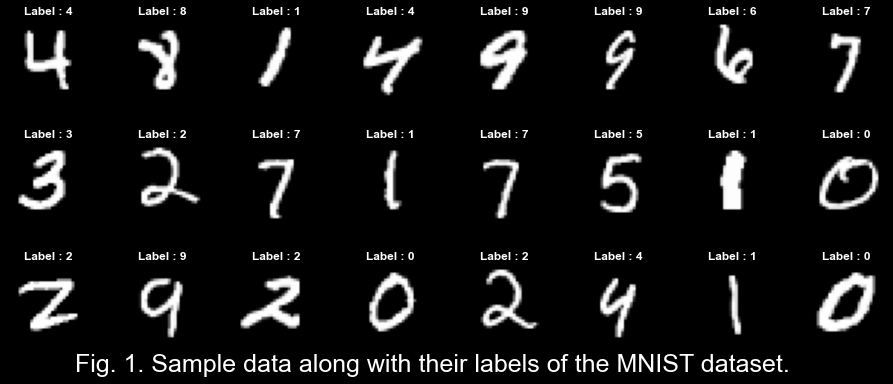

In [12]:
nrows = 3
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.5)

rand_idx = np.random.randint(0, len(X_train), size=nrows*ncols)
images = X_train[rand_idx]
labels = y_train[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i], cmap='Greys_r')
    ax.set_title('Label : {0}'.format(labels[i]), fontweight='bold',
                 color='white', pad=0)
    ax.axis('off')
    ax.grid(False)

plt.suptitle('Fig. 1. Sample data along with their labels of the MNIST dataset.',
             color='white', fontsize=axistitlesize+5, y=0.1)
    
plt.show()

#### Convert labels to one-hot encoded arrays and scale data

In [13]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 28,28, 1))
X_test = X_test.reshape((-1, 28,28, 1))
# Convert labels to one-hot encoded arrays
y_train = label_binarize(y_train, classes=np.unique(y_train))
y_test = label_binarize(y_test, classes=np.unique(y_test))

In [14]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (60000, 28, 28, 1)
y_train shape : (60000, 10)
X_test shape : (10000, 28, 28, 1)
y_test shape : (10000, 10)


### 1./b. Define model for task 1.

In [15]:
with tf.device('/device:GPU:0'):
    # Create checkpoint file to save best model into
    best_model_ex1 = kc.ModelCheckpoint('./models/best_model_ex1.hdf5', save_best_only=True, verbose=1)
    
    # Define the model
    cnn_model_ex1 = cnn_model(imsize=28, stride=1, kernelsize=3,
                              n_channels=1, num_of_filters=16, reg=5e-5,
                              padding='valid', activation='relu', n_class=10,
                              model_name='model_ex1')
    
    # Configure the model
    cnn_model_ex1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                          metrics=['accuracy'])

In [16]:
cnn_model_ex1.summary()

Model: "model_ex1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 16)        0 

### 1./c. Fitting the model

In [17]:
epochs_ex1 = 5

In [18]:
with tf.device('/device:GPU:0'):
    history_ex1 = cnn_model_ex1.fit(x=X_train,
                                    y=y_train,
                                    batch_size=32,
                                    epochs=epochs_ex1,
                                    verbose=1,
                                    validation_split=0.2,
                                    shuffle=True,
                                    callbacks=[best_model_ex1],
                                    initial_epoch=0,
                                    steps_per_epoch=None)

Epoch 1/5
1500/1500 [==============================] - 17s 7ms/step - loss: 0.4257 - accuracy: 0.8985 - val_loss: 0.1733 - val_accuracy: 0.9518

Epoch 00001: val_loss improved from inf to 0.17333, saving model to ./models\best_model_ex1.hdf5
Epoch 2/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0910 - accuracy: 0.9789 - val_loss: 0.0906 - val_accuracy: 0.9802

Epoch 00002: val_loss improved from 0.17333 to 0.09057, saving model to ./models\best_model_ex1.hdf5
Epoch 3/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0848 - accuracy: 0.9822 - val_loss: 0.1382 - val_accuracy: 0.9688

Epoch 00003: val_loss did not improve from 0.09057
Epoch 4/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0858 - accuracy: 0.9841 - val_loss: 0.1708 - val_accuracy: 0.9622

Epoch 00004: val_loss did not improve from 0.09057
Epoch 5/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0886 - accuracy: 0.9834 - val_loss: 0.1164

### 1./d. Evaluate loss and accuracy history

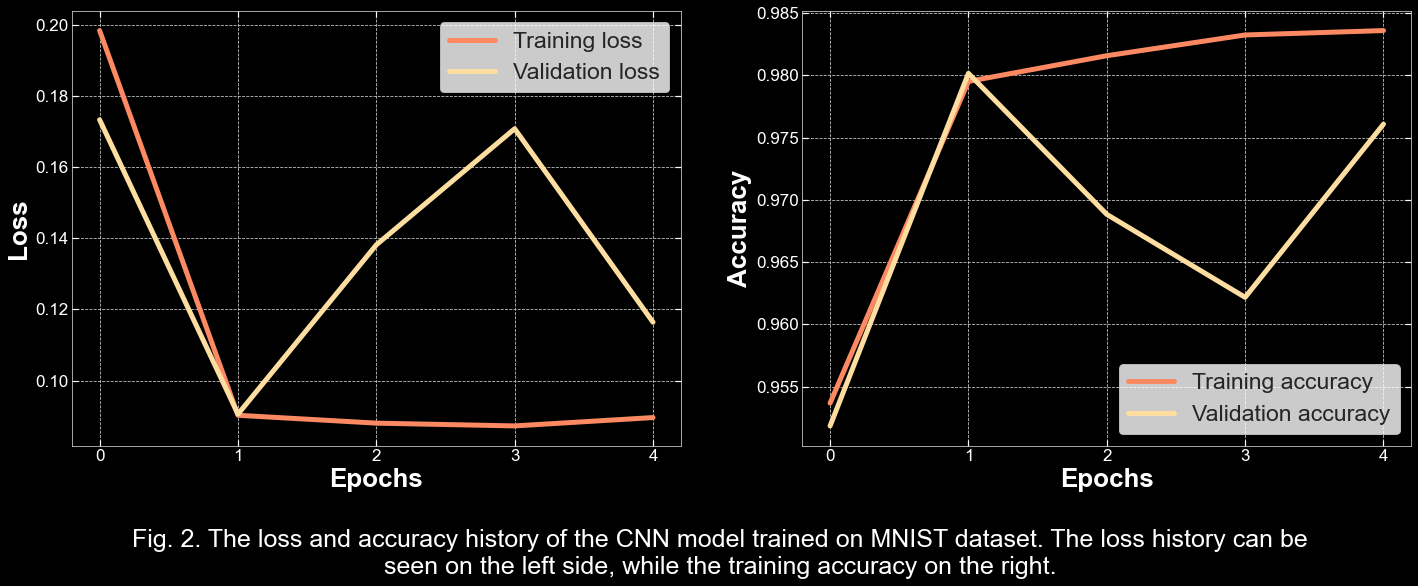

In [19]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# LOSS GRAPH
ax = axes[0]
ax.plot(history_ex1.epoch, history_ex1.history['loss'], label='Training loss',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex1.epoch, history_ex1.history['val_loss'], label='Validation loss',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Loss', fontsize=axislabelsize, fontweight='bold',
              color='white')

# ACCURACY GRAPH
ax = axes[1]
ax.plot(history_ex1.epoch, history_ex1.history['accuracy'], label='Training accuracy',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex1.epoch, history_ex1.history['val_accuracy'], label='Validation accuracy',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Accuracy', fontsize=axislabelsize, fontweight='bold',
              color='white')

for ax in axes.reshape(-1):
    ax.set_xlabel('Epochs', fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white')

    ax.legend(fontsize=axislegendsize)

plt.suptitle('Fig. 2. The loss and accuracy history of the CNN model trained on MNIST dataset. The loss history can be\n' +
             'seen on the left side, while the training accuracy on the right.',
             color='white',
             fontsize=axistitlesize+5, y=-0.02)
    
plt.show()

### 1./e. Make predictions with the model

In [20]:
y_pred = cnn_model_ex1.predict(X_test)

In [21]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_b = y_test.argmax(axis=-1)
y_pred_b = y_pred.argmax(axis=-1)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_b, y_pred=y_pred_b)
conf_mat = confusion_matrix(y_test_b, y_pred_b, labels=[i for i in range(0,10)])

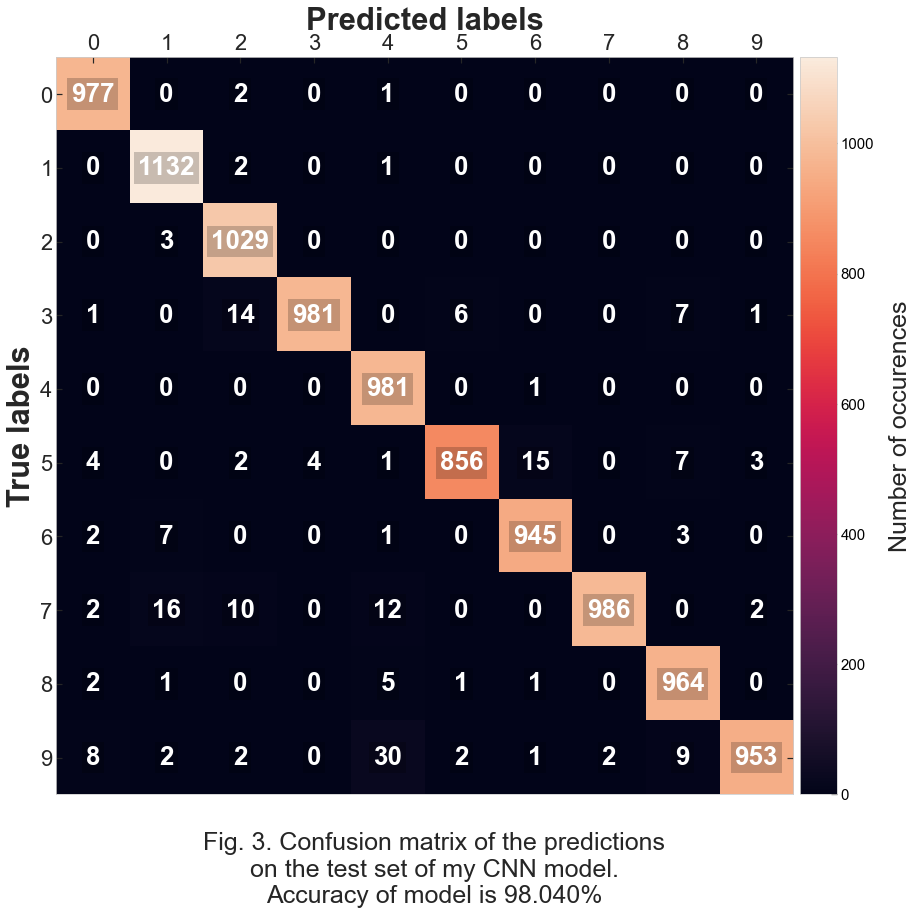

In [22]:
plot_confusion_matrix(conf_mat, y_test_b, labels=[i for i in range(0,10)],
                      title=('Fig. 3. Confusion matrix of the predictions\n' +
                             'on the test set of my CNN model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

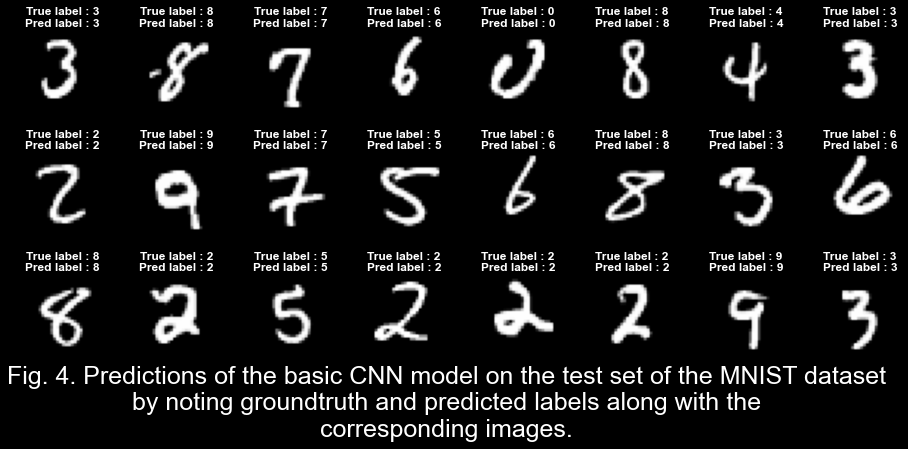

In [23]:
nrows = 3
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.5)

rand_idx = np.random.randint(0, len(X_test), size=nrows*ncols)
images = X_test[rand_idx]
labels_gr = y_test_b[rand_idx]
labels_tr = y_pred_b[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i].reshape((28,28)), cmap='Greys_r')
    ax.set_title('True label : {0}\nPred label : {1}'.format(labels_gr[i],
                                                             labels_tr[i]),
                 fontweight='bold', color='white', pad=0)
    ax.axis('off')
    ax.grid(False)

plt.suptitle('Fig. 4. Predictions of the basic CNN model on the test set of the MNIST dataset\n' +
             'by noting groundtruth and predicted labels along with the\n' +
             'corresponding images.',
             color='white', fontsize=axistitlesize+5, y=0.1)
    
plt.show()

## 2. Download the Street View House Numbers (SVHN) Dataset

- source: http://ufldl.stanford.edu/housenumbers/
- use the cropped dataset!
- to get the dataset use eg. wget and keep the original splitting, so download train and test matrix files
- preprocess the downloaded data to be able to use it for training and testing, so shapes should be same (except image sizes) as it was in ex 1.
- how many classes do we have in the dataset? how many train and test examples do we have?
- what is the dimension of the images?
- show 5 images from the dataset
- make one-hot encoding for the labels

### 2./a. Load and preprocess the SVHN dataset

The dataset at http://ufldl.stanford.edu/housenumbers/ isn't reachable for me at the moment I'm solving this assignment [at 2020-11-22T15:52:43.164052]. So I'm using another method to obtain and load the SVHN dataset.

Sources:
- Loading data:
    - https://www.machinecurve.com/index.php/2020/01/10/making-more-datasets-available-for-keras/
    - https://github.com/christianversloot/extra_keras_datasets/blob/master/extra_keras_datasets/svhn.py

This can reach the Stanford dataset (somehow...)

In [25]:
from extra_keras_datasets import svhn

In [26]:
(X_train, y_train), (X_test, y_test) = svhn.load_data(type='normal')
# Define SVHN classes in order
svhn_classes = [1,2,3,4,5,6,7,8,9,0]

In [27]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (73257, 32, 32, 3)
y_train shape : (73257,)
X_test shape : (26032, 32, 32, 3)
y_test shape : (26032,)


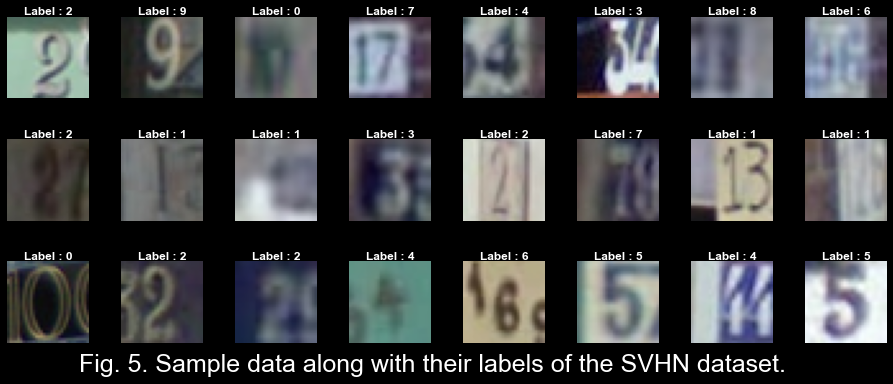

In [28]:
nrows = 3
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.5)

rand_idx = np.random.randint(0, len(X_train), size=nrows*ncols)
images = X_train[rand_idx]
labels = y_train[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i], cmap='Greys_r')
    ax.set_title('Label : {0}'.format(svhn_classes[labels[i]-1]), fontweight='bold',
                 color='white', pad=0)
    ax.axis('off')
    ax.grid(False)

plt.suptitle('Fig. 5. Sample data along with their labels of the SVHN dataset.',
             color='white', fontsize=axistitlesize+5, y=0.1)
    
plt.show()

### 2./c. Preprocess the dataset

In [29]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 32,32, 3))
X_test = X_test.reshape((-1, 32,32, 3))
# Convert labels to one-hot encoded arrays
y_train = label_binarize(y_train, classes=np.unique(y_train))
y_test = label_binarize(y_test, classes=np.unique(y_test))

In [30]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (73257, 32, 32, 3)
y_train shape : (73257, 10)
X_test shape : (26032, 32, 32, 3)
y_test shape : (26032, 10)


## 3. Train the CNN model seen in the 1st exercise for this dataset
* create a convolutional neural network
* the network should have the following layers:
        
        input (32, 32, 3)
        conv2D, 16 kernels, kernel size = 3, valid padding, relu actvation
        conv2D, 16 kernels, kernel size = 3, valid padding, relu actvation
        maxpooling kernel size = 2*2
        conv2D, 32 kernels, kernel size = 3, valid padding, relu actvation
        conv2D, 32 kernels, kernel size = 3, valid padding, relu actvation
        maxpooling kernel size = 2*2
        flatten
        dense, 10 neurons, softmax activation
        how many parameters do we have for each layer?

    * use Adam optimizer with default parameters
    * use categorical crossentropy as loss function
    * compile the model
    * print out a summary of the model
    * train the CNN on the training data for 15 epochs with batch size of 32
    * use the test data as validation data
- calculate the categorical cross-entropy loss and the accuracy! Hint: you should get at least ~80-90% accuracy

### 3./a. Define model for task 3.

In [31]:
with tf.device('/device:GPU:0'):
    # Create checkpoint file to save best model into
    best_model_ex3 = kc.ModelCheckpoint('./models/best_model_ex3.hdf5', save_best_only=True, verbose=1)
    
    # Define the model
    cnn_model_ex3 = cnn_model(imsize=32, stride=1, kernelsize=3,
                              n_channels=3, num_of_filters=16, reg=5e-5,
                              padding='valid', activation='relu', n_class=10,
                              model_name='model_ex3')
    
    # Configure the model
    cnn_model_ex3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                          metrics=['accuracy'])

In [32]:
cnn_model_ex3.summary()

Model: "model_ex3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 16)        0 

In [33]:
epochs_ex3 = 15

In [34]:
with tf.device('/device:GPU:0'):
    history_ex3 = cnn_model_ex3.fit(x=X_train,
                                    y=y_train,
                                    batch_size=32,
                                    epochs=epochs_ex3,
                                    verbose=1,
                                    validation_split=0.2,
                                    shuffle=True,
                                    callbacks=[best_model_ex3],
                                    initial_epoch=0,
                                    steps_per_epoch=None)

Epoch 1/15
1832/1832 [==============================] - 19s 9ms/step - loss: 1.5667 - accuracy: 0.4720 - val_loss: 1.4973 - val_accuracy: 0.5123

Epoch 00001: val_loss improved from inf to 1.49730, saving model to ./models\best_model_ex3.hdf5
Epoch 2/15
1832/1832 [==============================] - 15s 8ms/step - loss: 0.7577 - accuracy: 0.7775 - val_loss: 1.0488 - val_accuracy: 0.7005

Epoch 00002: val_loss improved from 1.49730 to 1.04877, saving model to ./models\best_model_ex3.hdf5
Epoch 3/15
1832/1832 [==============================] - 16s 9ms/step - loss: 0.6616 - accuracy: 0.8116 - val_loss: 0.6796 - val_accuracy: 0.8124

Epoch 00003: val_loss improved from 1.04877 to 0.67964, saving model to ./models\best_model_ex3.hdf5
Epoch 4/15
1832/1832 [==============================] - 16s 9ms/step - loss: 0.6060 - accuracy: 0.8312 - val_loss: 0.6738 - val_accuracy: 0.8181

Epoch 00004: val_loss improved from 0.67964 to 0.67378, saving model to ./models\best_model_ex3.hdf5
Epoch 5/15
1832/

## 4. Evaluate performance

- plot the training and the validation loss on the same plot!
- plot the training and the validation accuracy on the same plot!
- do we overfit?
- show the confusion matrix of the predictions (predicted values vs actual labels)
- where does the model make mistakes?

### 4./a. Evaluate loss and accuracy history

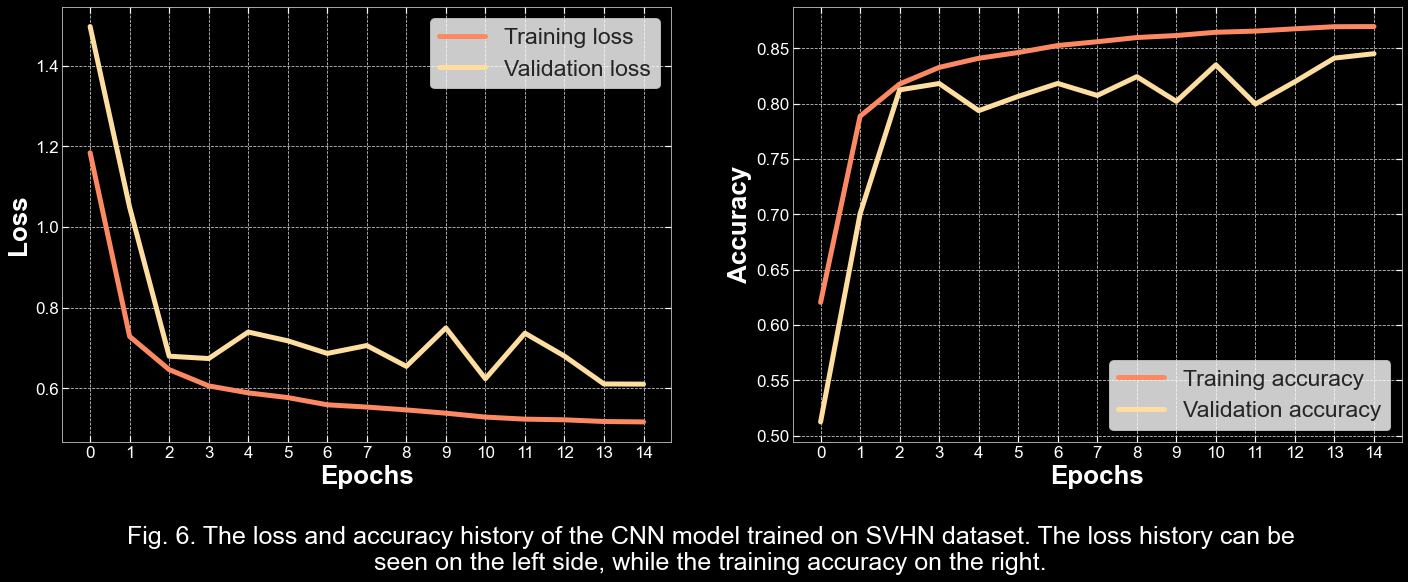

In [35]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# LOSS GRAPH
ax = axes[0]
ax.plot(history_ex3.epoch, history_ex3.history['loss'], label='Training loss',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex3.epoch, history_ex3.history['val_loss'], label='Validation loss',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Loss', fontsize=axislabelsize, fontweight='bold',
              color='white')

# ACCURACY GRAPH
ax = axes[1]
ax.plot(history_ex3.epoch, history_ex3.history['accuracy'], label='Training accuracy',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex3.epoch, history_ex3.history['val_accuracy'], label='Validation accuracy',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Accuracy', fontsize=axislabelsize, fontweight='bold',
              color='white')

for ax in axes.reshape(-1):
    ax.set_xlabel('Epochs', fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white')

    ax.legend(fontsize=axislegendsize)

plt.suptitle('Fig. 6. The loss and accuracy history of the CNN model trained on SVHN dataset. The loss history can be\n' +
             'seen on the left side, while the training accuracy on the right.',
             color='white',
             fontsize=axistitlesize+5, y=-0.02)
    
plt.show()

Overfit happens, when the validation loss starting to stagnate (or grow), while the training loss further decreases. That's exactly the case here, as seen on the graph.

### 4./b. Make predictions with the model

In [36]:
y_pred = cnn_model_ex3.predict(X_test)

In [37]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_b = y_test.argmax(axis=-1)
y_pred_b = y_pred.argmax(axis=-1)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_b, y_pred=y_pred_b)
conf_mat = confusion_matrix(y_test_b, y_pred_b, labels=svhn_classes)

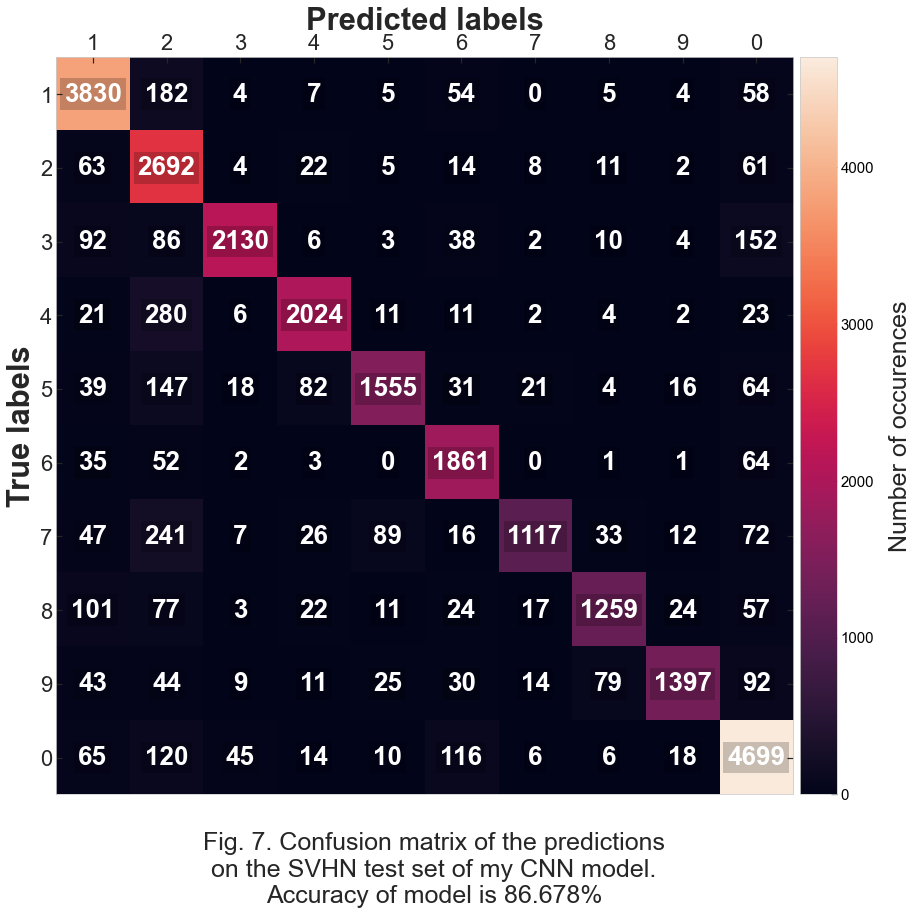

In [38]:
plot_confusion_matrix(conf_mat, y_test_b, labels=svhn_classes,
                      title=('Fig. 7. Confusion matrix of the predictions\n' +
                             'on the SVHN test set of my CNN model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

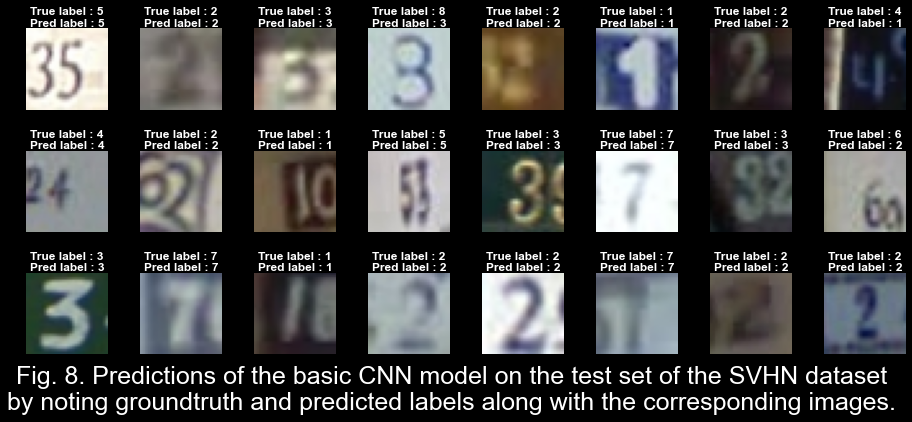

In [39]:
nrows = 3
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.5)

rand_idx = np.random.randint(0, len(X_test), size=nrows*ncols)
images = X_test[rand_idx]
labels_gr = y_test_b[rand_idx]
labels_tr = y_pred_b[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i])
    ax.set_title('True label : {0}\nPred label : {1}'.format(svhn_classes[labels_gr[i]],
                                                             svhn_classes[labels_tr[i]]),
                 fontweight='bold', color='white', pad=0)
    ax.axis('off')
    ax.grid(False)

plt.suptitle('Fig. 8. Predictions of the basic CNN model on the test set of the SVHN dataset\n' +
             'by noting groundtruth and predicted labels along with the corresponding images.',
             color='white', fontsize=axistitlesize+5, y=0.1)
    
plt.show()

## 5. Train an other CNN
- as we can see the previous architecture can be further improved
- come up with an architecture that can achieve more than 91% accuracy on the test set
- print out the summary for this model!
- plot the loss and accuracy curves for this model too!

### 5./a. Create and fit better model

- Added another convolutional block to the network
- Changed initial number of filters from `16` to `32`
- Changed learning rate from `0.005` to `0.004`
- Changed padding from `valid` to `same`
- Added early stopping with `patience=10` epochs

In [40]:
with tf.device('/device:GPU:0'):
    # Create checkpoint file to save best model into
    best_model_ex5 = kc.ModelCheckpoint('./models/best_model_ex5.hdf5', save_best_only=True, verbose=1)
    # Configure early stopping with N epochs of patience
    es_ex5 = kc.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    
    # Define the model
    cnn_model_ex5 = better_cnn_model(imsize=32, stride=1, kernelsize=3,
                                     n_channels=3, num_of_filters=32,
                                     padding='same', activation='relu', n_class=10,
                                     model_name='model_ex5')
    
    # Configure the model
    cnn_model_ex5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
                          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                          metrics=['accuracy'])

In [41]:
cnn_model_ex5.summary()

Model: "model_ex5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0 

In [42]:
epochs_ex5 = 100

In [43]:
with tf.device('/device:GPU:0'):
    history_ex5 = cnn_model_ex5.fit(x=X_train,
                                    y=y_train,
                                    batch_size=32,
                                    epochs=epochs_ex5,
                                    verbose=1,
                                    validation_split=0.2,
                                    shuffle=True,
                                    callbacks=[es_ex5, best_model_ex5],
                                    initial_epoch=0,
                                    steps_per_epoch=None)

Epoch 1/100
1832/1832 [==============================] - 27s 12ms/step - loss: 1.7522 - accuracy: 0.4024 - val_loss: 0.8811 - val_accuracy: 0.7734

Epoch 00001: val_loss improved from inf to 0.88108, saving model to ./models\best_model_ex5.hdf5
Epoch 2/100
1832/1832 [==============================] - 22s 12ms/step - loss: 0.4839 - accuracy: 0.8941 - val_loss: 0.6196 - val_accuracy: 0.8524

Epoch 00002: val_loss improved from 0.88108 to 0.61955, saving model to ./models\best_model_ex5.hdf5
Epoch 3/100
1832/1832 [==============================] - 21s 12ms/step - loss: 0.4541 - accuracy: 0.9117 - val_loss: 0.5423 - val_accuracy: 0.8795

Epoch 00003: val_loss improved from 0.61955 to 0.54230, saving model to ./models\best_model_ex5.hdf5
Epoch 4/100
1832/1832 [==============================] - 21s 12ms/step - loss: 0.4168 - accuracy: 0.9208 - val_loss: 0.5054 - val_accuracy: 0.8888

Epoch 00004: val_loss improved from 0.54230 to 0.50535, saving model to ./models\best_model_ex5.hdf5
Epoch 5/

### 5./b. Evaluate loss and accuracy history

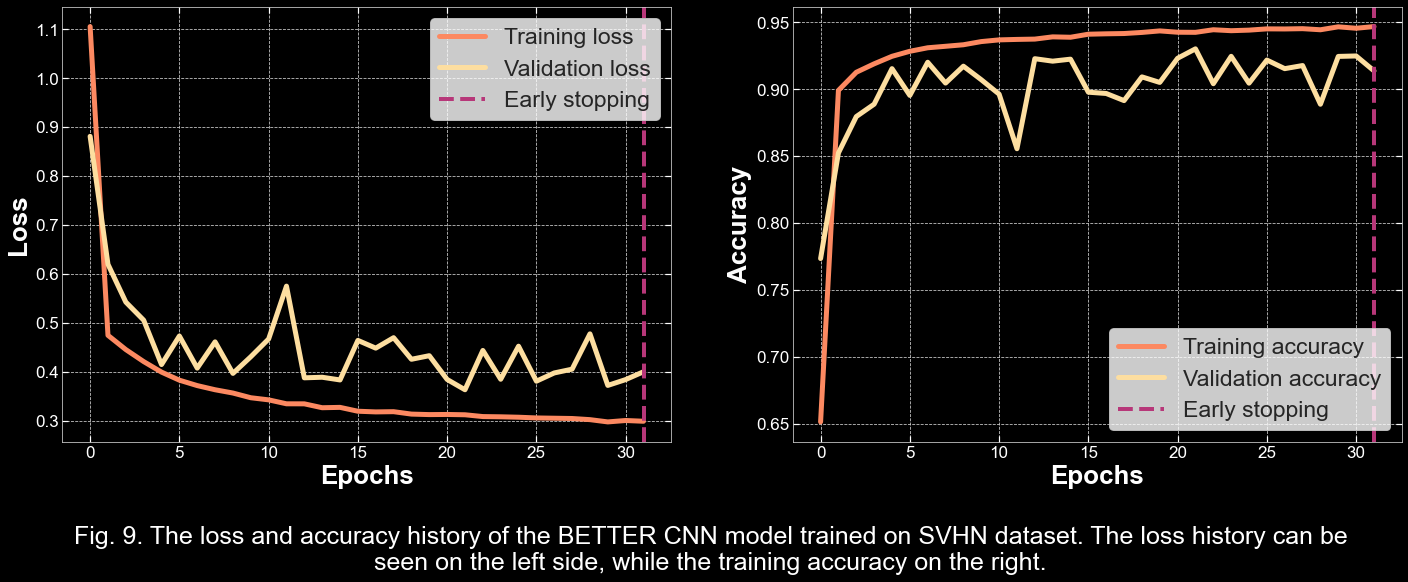

In [44]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# LOSS GRAPH
ax = axes[0]
ax.plot(history_ex5.epoch, history_ex5.history['loss'], label='Training loss',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex5.epoch, history_ex5.history['val_loss'], label='Validation loss',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Loss', fontsize=axislabelsize, fontweight='bold',
              color='white')

# ACCURACY GRAPH
ax = axes[1]
ax.plot(history_ex5.epoch, history_ex5.history['accuracy'], label='Training accuracy',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex5.epoch, history_ex5.history['val_accuracy'], label='Validation accuracy',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Accuracy', fontsize=axislabelsize, fontweight='bold',
              color='white')

for ax in axes.reshape(-1):
    if epochs_ex5 > history_ex5.epoch[-1] : ax.axvline(x=history_ex5.epoch[-1], label='Early stopping',
                                                       color=cm.magma(0.5), ls='--', lw=4)
    ax.set_xlabel('Epochs', fontsize=axislabelsize, fontweight='bold',
                  color='white')
    #ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white')

axes[0].legend(loc='upper right', fontsize=axislegendsize)
axes[1].legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 9. The loss and accuracy history of the BETTER CNN model trained on SVHN dataset. The loss history can be\n' +
             'seen on the left side, while the training accuracy on the right.',
             color='white',
             fontsize=axistitlesize+5, y=-0.02)
    
plt.show()

### 5./c. Make predictions with the model

In [45]:
y_pred = cnn_model_ex5.predict(X_test)

In [46]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_b = y_test.argmax(axis=-1)
y_pred_b = y_pred.argmax(axis=-1)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_b, y_pred=y_pred_b)
conf_mat = confusion_matrix(y_test_b, y_pred_b, labels=svhn_classes)

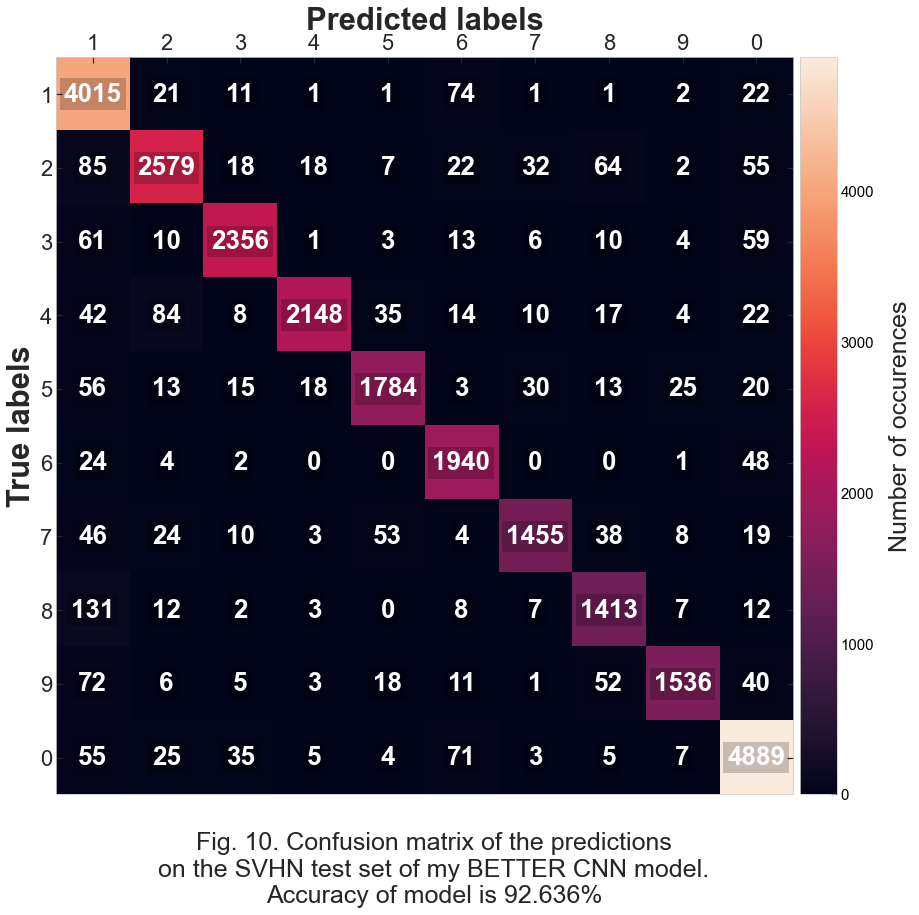

In [47]:
plot_confusion_matrix(conf_mat, y_test_b, labels=svhn_classes,
                      title=('Fig. 10. Confusion matrix of the predictions\n' +
                             'on the SVHN test set of my BETTER CNN model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

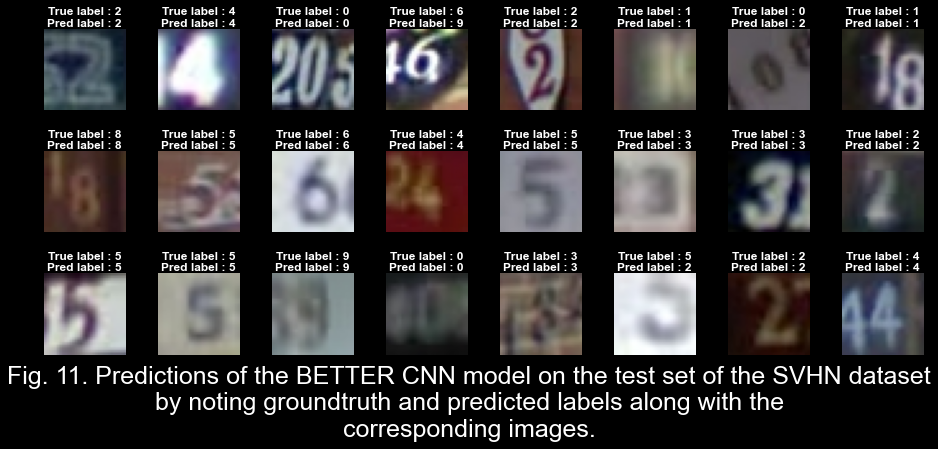

In [48]:
nrows = 3
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.5)

rand_idx = np.random.randint(0, len(X_test), size=nrows*ncols)
images = X_test[rand_idx]
labels_gr = y_test_b[rand_idx]
labels_tr = y_pred_b[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i])
    ax.set_title('True label : {0}\nPred label : {1}'.format(svhn_classes[labels_gr[i]],
                                                             svhn_classes[labels_tr[i]]),
                 fontweight='bold', color='white', pad=0)
    ax.axis('off')
    ax.grid(False)

plt.suptitle('Fig. 11. Predictions of the BETTER CNN model on the test set of the SVHN dataset\n' +
             'by noting groundtruth and predicted labels along with the\n' +
             'corresponding images.',
             color='white', fontsize=axistitlesize+5, y=0.1)
    
plt.show()